<a href="https://colab.research.google.com/github/Luizpsj20-inteli/Ponderadas/blob/main/Lunar_Lander_Luiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install -y ffmpeg
!apt-get install xvfb
!apt-get install swig3.0
%pip install pyvirtualdisplay
%pip install gym
%pip install Pillow
%pip install swig
%pip install gym[box2d]

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading p

In [ ]:
import tensorflow as tf
import gym
import numpy as np
import PIL.Image


import time
from collections import deque
from collections import namedtuple

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE

In [ ]:
MEMORY_SIZE = 100_000
GAMMA = 0.997
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 5

In [ ]:
import base64
import random
from itertools import zip_longest

import pandas as pd
import IPython
import imageio
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.iolib.table import SimpleTable

# Constantes
SEED = 3
MINIBATCH_SIZE = 64
TAU = 1e-3
E_DECAY = 0.995
E_MIN = 0.01

# Define a semente aleatória
random.seed(SEED)

def get_experiences(memory_buffer):
    """
    Obtém experiências da memória.
    """
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(
        np.array([e.state for e in experiences if e is not None]),
        dtype=tf.float32
    )
    actions = tf.convert_to_tensor(
        np.array([e.action for e in experiences if e is not None]),
        dtype=tf.float32
    )
    rewards = tf.convert_to_tensor(
        np.array([e.reward for e in experiences if e is not None]),
        dtype=tf.float32
    )
    next_states = tf.convert_to_tensor(
        np.array([e.next_state for e in experiences if e is not None]),
        dtype=tf.float32
    )
    done_vals = tf.convert_to_tensor(
        np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
        dtype=tf.float32
    )
    return states, actions, rewards, next_states, done_vals

def check_update_conditions(t, num_steps_upd, memory_buffer):
    """
    Verifica se as condições para atualização são atendidas.
    """
    return (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE

def get_new_eps(epsilon):
    """
    Calcula o novo valor de ε.
    """
    return max(E_MIN, E_DECAY * epsilon)

def get_action(q_values, epsilon=0):
    """
    Obtém a ação com base nos valores Q e ε.
    """
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))

def update_target_network(q_network, target_q_network):
    """
    Atualiza a rede Q alvo.
    """
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Plota o histórico de recompensas.
    """
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit, upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
    plt.xlabel('Episódio', color=text_color, fontsize=30)
    plt.ylabel('Pontuação total', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

def display_table(initial_state, action, next_state, reward, done):
    """
    Mostra a tabela com o estado inicial, ação, próximo estado, recompensa recebida e se o episódio terminou.
    """
    action_labels = ["Fazer nada", "Disparar motor direito", "Disparar motor principal", "Disparar motor esquerdo"]
    column_headers = None  # Não usar cabeçalhos de coluna

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Estado inicial:", [f"{initial_state}"]),
                      ("Ação:", [f"{action_labels[action]}"]),
                      ("Próximo estado:", [f"{next_state}"]),
                      ("Recompensa recebida:", [f"{reward:.3f}"]),
                      ("Episódio encerrado:", [f"{done}"])]

    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)
    return table

def embed_mp4(filename):
    """
    Incorpora um arquivo mp4 no notebook.
    """
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Seu navegador não suporta a tag de vídeo.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def create_video(filename, env, q_network, fps=30):
    """
    Cria um vídeo do ambiente com as ações escolhidas pela rede Q.
    """
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state = env.reset()
        frame = env.render(mode="rgb_array")
        video.append_data(frame)
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            state, _, done, _ = env.step(action)
            frame = env.render(mode="rgb_array")
            video.append_data(frame)


In [ ]:
# Display do ambiente do Lunar Lander
Display(visible=0, size=(840, 480)).start();

tf.random.set_seed(SEED)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


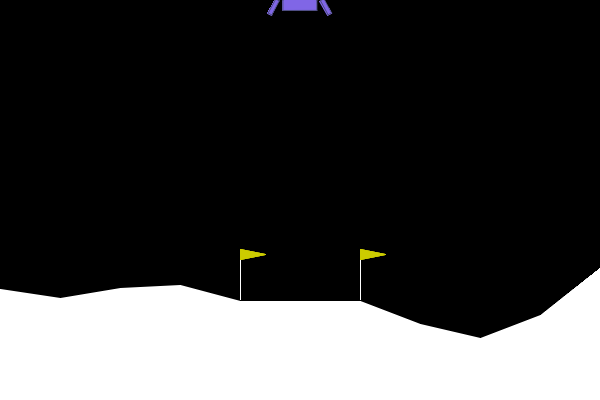

In [ ]:
#plotar a imagem base
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [ ]:
# Resetar o ambiente e obter o estado inicial
initial_state = env.reset()

In [ ]:
action = 0

next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Estado Inicial:", initial_state)
    print("Ação:", action)
    print("Próximo Estado:", next_state)
    print("Recompensa Recebida:", reward)
    print("Episódio Terminado:", done)
    print("Informação:", info)

Estado Inicial: [-0.001 1.408 -0.129 -0.124 0.001 0.029 0.000 0.000]
Ação: 0
Próximo Estado: [-0.003 1.405 -0.128 -0.150 0.003 0.029 0.000 0.000]
Recompensa Recebida: -1.6635695357469444
Episódio Terminado: False
Informação: {}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
# Rede Q
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Rede Q-Alvo (target)
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

optimizer = Adam(learning_rate=ALPHA)


In [ ]:
# Guarda experiências em uma tupla nomeada
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    states, actions, rewards, next_states, done_vals = experiences

    # Max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Se y = R o episódio termina, se não y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Q values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Loss
    loss = MSE(y_targets, q_values)

    return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):

    # Calcula a perda
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Obtém os gradientes da perda em relação aos pesos.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Atualiza os pesos da q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # Atualiza os pesos da rede q_network alvo
    update_target_network(q_network, target_q_network)

In [ ]:
start = time.time()

num_episodes = 1500
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100
epsilon = 1.0

memory_buffer = deque(maxlen=MEMORY_SIZE)

# Define os pesos da rede target
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        next_state, reward, done, _ = env.step(action)

        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            experiences = get_experiences(memory_buffer)

            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    epsilon = get_new_eps(epsilon)

    print(f"\rEpisódio {i+1} | Média de pontos total dos últimos {num_p_av} episódios: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisódio {i+1} | Média de pontos total dos últimos {num_p_av} episódios: {av_latest_points:.2f}")

    if av_latest_points >= 200.0:
        print(f"\n\nAmbiente resolvido em {i+1} episódios!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTempo Total: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episódio 100 | Média de pontos total dos últimos 100 episódios: -150.08
Episódio 200 | Média de pontos total dos últimos 100 episódios: -115.95
Episódio 300 | Média de pontos total dos últimos 100 episódios: -90.06
Episódio 400 | Média de pontos total dos últimos 100 episódios: -26.25
Episódio 500 | Média de pontos total dos últimos 100 episódios: 79.87
Episódio 600 | Média de pontos total dos últimos 100 episódios: 114.37
Episódio 700 | Média de pontos total dos últimos 100 episódios: 162.42
Episódio 768 | Média de pontos total dos últimos 100 episódios: 199.82

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episódio 769 | Média de pontos total dos últimos 100 episódios: 200.06

Ambiente resolvido em 769 episódios!

Tempo Total: 1982.60 s (33.04 min)


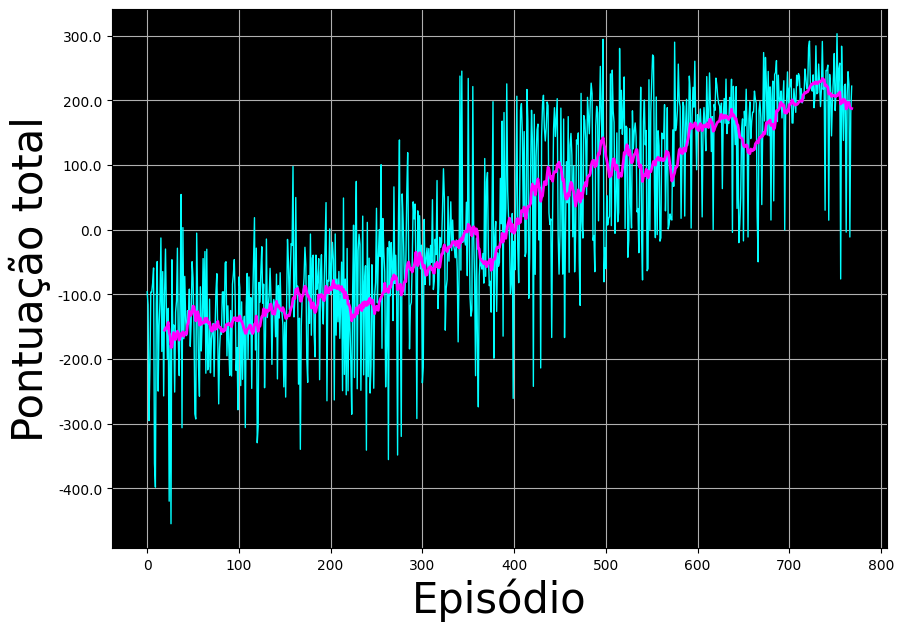

In [ ]:
# Plotar o histórico de pontos
plot_history(total_point_history)


In [ ]:
# Suprimir avisos da biblioteca imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
filename = "lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)